In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:

import matplotlib.pyplot as plt
import pandas as pd

# Cargar la primera hoja (Informe alumnos)
file_path = '/content/drive/MyDrive/Base de datos SIGA 24022025.xlsx'
df_alumnos = pd.read_excel(file_path, sheet_name='Informe alumnos')

# Cargar la segunda hoja (Datos Clinicos de PC)
df_clinicos = pd.read_excel(file_path, sheet_name='Datos clínicos de PC')
df_clinicos = df_clinicos.rename(columns={'Matricula': 'Matrícula'})
# Combinar los DataFrames usando la columna 'matricula'
df = pd.merge(df_alumnos, df_clinicos, on='Matrícula', how='left')
df.info()
#Quitamos columna ruta por muy poca cantidad de datos
df = df.drop('Ruta',axis =1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 63 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Matrícula                                 1427 non-null   int64         
 1   Fecha de Nacimiento                       1427 non-null   datetime64[ns]
 2   Edad (a 12/02/2025)                       1427 non-null   object        
 3   Sexo                                      1342 non-null   object        
 4   Tipo                                      1427 non-null   object        
 5   Estatus                                   1427 non-null   object        
 6   Programa                                  1427 non-null   object        
 7   Grupo                                     590 non-null    object        
 8   Inscripción / Reinscripción               1426 non-null   object        
 9   Transporte del INA            

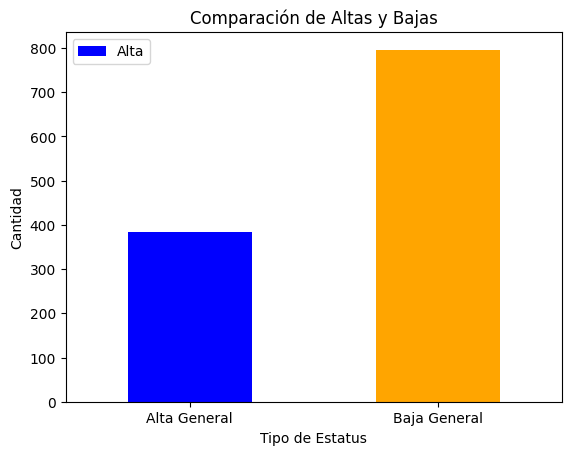

In [204]:
df['Alta General'] = df['Estatus'].str.contains('Alta', case=False).astype(object)
df['Baja General'] = df['Estatus'].str.contains('Baja', case=False).astype(object)
df_grouped = df[['Alta General', 'Baja General']].sum()

df_grouped.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Tipo de Estatus')
plt.ylabel('Cantidad')
plt.title('Comparación de Altas y Bajas')
plt.xticks(rotation=0)
plt.legend(['Alta', 'Baja'])
plt.show()

In [205]:
#Eliminar variables de dias, no son necesarias
df = df.drop(["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"], axis =1)

In [206]:
#Renombrar todos los camiones a solo Camion
# Lista de columnas a modificar
columnas_transporte = ["Medio de Traslado (Ficha Inicial)", "Medio de Traslado (Transportación)"]

# Reemplazar valores en las columnas seleccionadas
df[columnas_transporte] = df[columnas_transporte].replace(
    {"1 Camión": "Camión", "2 Camiones": "Camión", "3 Camiones o más": "Camión"}
)

# Verificar los cambios
print(df[columnas_transporte].head())


  Medio de Traslado (Ficha Inicial) Medio de Traslado (Transportación)
0                       Auto propio                        Auto propio
1                               NaN                                NaN
2                            Camión                             Camión
3                              Taxi                               Taxi
4                               NaN                                NaN


In [207]:
#Limpieza de estado y ciudad
conteo_ciudades = df["Ciudad"].value_counts(dropna=False)
datos_faltantes = df["Ciudad"].isna().sum()

filtros = df['Ciudad'].isnull() & df['Estado'].notnull()
observaciones_faltantes = df.loc[filtros, ['Ciudad', 'Estado']]

if 'Estado' in df.columns:
    df['Estado'] = df['Estado'].replace({'NUEVO LEON': 'Nuevo León'})


df.loc[(df['Ciudad'].isnull()) & (df['Estado'] == 'Nuevo León'), 'Ciudad'] = 'MONTERREY'
df.loc[(df['Ciudad'].isnull()) & (df['Estado'] == 'Coahuila'), 'Ciudad'] = 'SALTILLO'
df.loc[(df['Ciudad'].isnull()) & (df['Estado'] == 'Tamaulipas'), 'Ciudad'] = 'NUEVO LAREDO'
df.loc[(df['Ciudad'].isnull()) & (df['Estado'] == 'San Luis Potosí'), 'Ciudad'] = 'SAN LUIS POTOSÍ'
df.loc[(df['Ciudad'].isnull()) & (df['Estado'] == 'Jalisco'), 'Ciudad'] = 'GUADALAJARA'
df.loc[(df['Ciudad'].isnull()) & (df['Estado'] == 'Quintana Roo'), 'Ciudad'] = 'CANCÚN'


municipios_nl = [
    'MONTERREY', 'SAN NICOLAS DE LOS GARZA', 'GUADALUPE', 'MONTEMORELOS',
    'SANTA CATARINA', 'SALINAS VICTORIA', 'JUAREZ', 'APODACA'
]

df.loc[(df['Estado'].isnull()) & (df['Ciudad'].isin(municipios_nl)), 'Estado'] = 'Nuevo León'
df.loc[(df['Estado'].isnull()) & (df['Ciudad'] == 'SALTILLO'), 'Estado'] = 'Coahuila'

moda_estado = df['Estado'].mode()[0]
df['Estado'].fillna(moda_estado, inplace=True)

# Llenar los NaN en la columna 'Ciudad' con la moda de 'Ciudad'
moda_ciudad = df['Ciudad'].mode()[0]
df['Ciudad'].fillna(moda_ciudad, inplace=True)

# Rellenar el 'Lugar de Nacimiento' según el hospital
df.loc[(df['Hospital donde nació'] == 'Clínica Nova') & (df['Lugar de Nacimiento'].isnull()), 'Lugar de Nacimiento'] = 'SAN NICOLAS DE LOS GARZA'
df.loc[(df['Hospital donde nació'] == 'Hospital Universitario') & (df['Lugar de Nacimiento'].isnull()), 'Lugar de Nacimiento'] = 'MONTERREY'

#LUGAR DE NACIMIENTO
df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'MONTERREY,N.L' if 'MONTER' in x.upper() else x
)

df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'SAN NICOLAS DE LOS GARZA,N.L' if 'SAN NICO' in x.upper() else x
)

df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'APODACA,N.L' if 'APODACA' in x.upper() else x
)

df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'GUADALUPE,N.L' if 'GUADALUPE' in x.upper() else x
)

df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'SANTA CATARINA,N.L' if 'SANTA CATA' in x.upper() else x
)

df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'SAN PEDRO GARZA GARCIA,N.L' if 'SAN PEDRO GARZA' in x.upper() else x
)

df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'ESCOBEDO,N.L' if 'ESCOBEDO' in x.upper() else x
)
df['Lugar de Nacimiento'] = df['Lugar de Nacimiento'].astype(str).apply(
    lambda x: 'GARCIA,N.L' if 'GARCÍA' in x.upper() else x
)

moda_Lugar = df['Lugar de Nacimiento'].mode()[0]
print("Moda de la columna 'Lugar de Nacimiento':", moda_Lugar)
df['Lugar de Nacimiento'].fillna(moda_Lugar, inplace=True)

# Listas de clasificación
monterrey = ["MONTERREY,N.L", "M,ONTERREY N.L. GINE"]
area_metropolitana = [
    "SAN NICOLAS DE LOS GARZA,N.L", "APODACA,N.L", "GUADALUPE,N.L",
    "SAN PEDRO", "SANTA CATARINA,N.L", "ESCOBEDO,N.L", "GARCIA",
    "SAN PEDRO GARZA GARCIA,N.L", "ZUAZUA", "CADEREYTA JIMENEZ, N.L",

]

# Función para clasificar
def clasificar_ciudad(ciudad):
    if ciudad in monterrey:
        return "MONTERREY"
    elif ciudad in area_metropolitana:
        return "ÁREA METROPOLITANA"
    else:
        return "OTROS"

# Aplicar la clasificación
df["Categoria_Lugar"] = df["Lugar de Nacimiento"].apply(clasificar_ciudad)

# Ver los resultados
print(df["Categoria_Lugar"].value_counts())

Moda de la columna 'Lugar de Nacimiento': MONTERREY,N.L
Categoria_Lugar
MONTERREY             913
ÁREA METROPOLITANA    295
OTROS                 219
Name: count, dtype: int64


/tmp/ipython-input-3084777264.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Estado'].fillna(moda_estado, inplace=True)
/tmp/ipython-input-3084777264.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [208]:
# ********************* CANDELARIA ***********************
# convertir edad a dias
from datetime import datetime

reference_date = datetime(2025, 8, 11)


# Convert 'Fecha de Nacimiento' and 'Fecha de Ingreso' columns to datetime objects
df['Fecha de Nacimiento'] = pd.to_datetime(df['Fecha de Nacimiento'])
df['Fecha de registro como candidato'] = pd.to_datetime(df['Fecha de registro como candidato'])
df['Fecha de ingreso al INA'] = pd.to_datetime(df['Fecha de ingreso al INA'])
df['Fecha de evaluación'] = pd.to_datetime(df['Fecha de evaluación'])


# Convert datetime columns to numerical representation (days since epoch)
# You can choose a reference date or use Unix epoch (1970-01-01)
reference_date_1 = pd.Timestamp('1970-01-01')
reference_date_2 = pd.Timestamp('2025-08-11')
df['Fecha de Ingreso_num'] = (pd.Timestamp('today') - df['Fecha de registro como candidato']).dt.days
df['Fecha de ingreso al INA_num'] = (pd.Timestamp('today') - df['Fecha de ingreso al INA']).dt.days
df['Fecha de evaluación_num'] = (pd.Timestamp('today') - df['Fecha de evaluación']).dt.days

df['Fecha de nacimiento en dias'] = (pd.Timestamp('today') - df['Fecha de Nacimiento']).dt.days

# Agregar una columna de referencia (Edad en años)
df['Edad en años'] = ((pd.Timestamp('today') - df['Fecha de Nacimiento']).dt.days / 365.25).round()
print(df[['Fecha de Nacimiento', 'Fecha de nacimiento en dias','Edad en años']])


     Fecha de Nacimiento  Fecha de nacimiento en dias  Edad en años
0             1990-09-08                        12756          35.0
1             1993-02-24                        11856          32.0
2             1991-07-05                        12456          34.0
3             1990-09-28                        12736          35.0
4             1991-07-31                        12430          34.0
...                  ...                          ...           ...
1422          2020-12-19                         1696           5.0
1423          2014-03-24                         4158          11.0
1424          2018-06-08                         2621           7.0
1425          2018-05-20                         2640           7.0
1426          2015-11-26                         3546          10.0

[1427 rows x 3 columns]


In [209]:
# ****************CANDELARIA****************
#Variables a eliminar
# Se elimino la columna "Edad a fecha de registro "  y "Edad (a 12/02/2025)", porque ya se tiene la edad en dias y años en las nuevas columnas
variables_a_eliminar = ["Medio de Traslado (Ficha Inicial)", "Tiempo de Recorrido Casa-Instituto", "Lugar de Nacimiento",'Edad a fecha de registro', 'Edad (a 12/02/2025)','Fecha de evaluación','Fecha de Nacimiento','Fecha de registro como candidato','Fecha de ingreso al INA']
df = df.drop(variables_a_eliminar, axis = 1)

# Ver si se efectuaron los cambios en el dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Matrícula                                 1427 non-null   int64  
 1   Sexo                                      1342 non-null   object 
 2   Tipo                                      1427 non-null   object 
 3   Estatus                                   1427 non-null   object 
 4   Programa                                  1427 non-null   object 
 5   Grupo                                     590 non-null    object 
 6   Inscripción / Reinscripción               1426 non-null   object 
 7   Transporte del INA                        523 non-null    object 
 8   Clínica de Adscripción en el IMSS         703 non-null    object 
 9   Inst. en la que reciben servicio médico   1355 non-null   object 
 10  Ciudad                              

In [210]:
# Corregir los tipos de variable incorrectos
df['Ingreso Per Cápita'] = pd.to_numeric(df['Ingreso Per Cápita'], errors='coerce')
# Ver si se corrijió el tipo de variable

In [211]:
# Imputación CON Kmeans
from sklearn.impute import KNNImputer
# Select only numerical columns for imputation
numerical_df = df.select_dtypes(include=['number'])
# Perform imputation on numerical features
imputer = KNNImputer(n_neighbors=5)
df_imputed_n = pd.DataFrame(imputer.fit_transform(numerical_df),
                         columns=numerical_df.columns,
                         index=numerical_df.index)


In [212]:
categorical_features = df.select_dtypes(exclude = ['number',])
df_mediano = pd.concat([df_imputed_n, categorical_features], axis = 1)

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def imputar_categoricas_guardar(df, columnas_cat):
    df_imputado = pd.DataFrame(index=df.index)  # DataFrame vacío con mismo índice

    for col in columnas_cat:
        df_temp = df.copy()

        # Variables predictoras
        X = df_temp.drop(columns=[col])
        X = pd.get_dummies(X, drop_first=True)  # OneHot para variables categóricas

        # Filtrar filas con y sin datos en col
        mask_no_nan = df_temp[col].notna()
        mask_nan = df_temp[col].isna()

        if mask_nan.sum() == 0:
            df_imputado[col] = df_temp[col]  # No había NaNs
            continue

        X_train = X[mask_no_nan]
        y_train = df_temp.loc[mask_no_nan, col]
        X_pred = X[mask_nan]

        # Entrenar modelo
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Predecir faltantes
        y_pred = model.predict(X_pred)

        # Reconstruir columna imputada
        col_imputada = df_temp[col].copy()
        col_imputada[mask_nan] = y_pred

        # Guardar en el nuevo DataFrame
        df_imputado[col] = col_imputada

    return df_imputado



In [214]:
variables_a_imputar = [
    'Sexo', 'Grupo',
    'Inscripción / Reinscripción', 'Transporte del INA',
    'Clínica de Adscripción en el IMSS', 'Inst. en la que reciben servicio médico',
    'Hospital donde nació',
    'Medio x el cual se enteró de Institución', 'Motivo de baja',
    'Ocupación del padre', 'Ocupación de la madre',
    'Escolaridad del padre', 'Escolaridad de la madre',
    'Integrantes Familia (Incluye al alumno)', 'Especifique Otros Gastos',
    'Nivel Socioeconómico', 'Medio de Traslado (Transportación)',
    'Diagnóstico Etiológico', 'Diagnostico Fisiologico',
    'Diagnostico Funcional', 'Diagnostico Topografico', 'Nivel GMFCS'
]

for col in variables_a_imputar:
    df_imputed_c = imputar_columna_categorica(df_mediano, col)

Imputación completada para: Sexo
Imputación completada para: Grupo
Imputación completada para: Inscripción / Reinscripción
Imputación completada para: Transporte del INA
Imputación completada para: Clínica de Adscripción en el IMSS
Imputación completada para: Inst. en la que reciben servicio médico
Imputación completada para: Hospital donde nació
Imputación completada para: Medio x el cual se enteró de Institución
Imputación completada para: Motivo de baja
Imputación completada para: Ocupación del padre
Imputación completada para: Ocupación de la madre
Imputación completada para: Escolaridad del padre
Imputación completada para: Escolaridad de la madre
Imputación completada para: Integrantes Familia (Incluye al alumno)
Imputación completada para: Especifique Otros Gastos
Imputación completada para: Nivel Socioeconómico
Imputación completada para: Medio de Traslado (Transportación)
Imputación completada para: Diagnóstico Etiológico
Imputación completada para: Diagnostico Fisiologico
Imp

In [215]:
df_imputed_c = df_imputed_c.select_dtypes(exclude = ['number',])
df_imputed = pd.concat([df_imputed_n, df_imputed_c], axis = 1)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Matrícula                                 1427 non-null   float64
 1   Número de hermanos en la familia          1427 non-null   float64
 2   Ingresos por apoyo gubernamental          1427 non-null   float64
 3   Total de ingresos mensuales               1427 non-null   float64
 4   Total de egresos                          1427 non-null   float64
 5   Ingreso Per Cápita                        1427 non-null   float64
 6   Gastos de Agua                            1427 non-null   float64
 7   Gastos de Educación                       1427 non-null   float64
 8   Gastos de Casa                            1427 non-null   float64
 9   Gastos de Entretenimiento                 1427 non-null   float64
 10  Gastos de Gas                       

In [216]:
#Imputación con moda
#categorical_features = df.select_dtypes(exclude = ['number',])
#Dropear timestap por ahora nomas
#categorical_features.info()

#for column in categorical_features.columns:
    # Calculate the mode of the column
#    mode_value = categorical_features[column].mode()[0]

    # Impute missing values with the mode
#    categorical_features[column] = categorical_features[column].fillna(mode_value)


In [217]:
import numpy as np
#Antes de este paso debe ir la imputación, pq si no todos los NaNs se hacen cero y eso esta mal
#Variables si tiene alguno de los servicios que nos interesan
#Para comparar con la tabla de excel hay que restarle dos a la fila en el iloc
df_imputed['Internet_si'] = np.where((df['Gastos de Internet'] != 0) & (~df['Gastos de Internet'].isnull()), 1, 0)
df_imputed['Teléfono_si'] = np.where((df['Gastos de Teléfono Local/Celular'] != 0) & (~df['Gastos de Teléfono Local/Celular'].isnull()), 1, 0)
df_imputed['Luz_si'] = np.where((df['Gastos de Luz'] != 0) & (~df['Gastos de Luz'].isnull()), 1, 0)
print(df_imputed['Internet_si'].iloc[44])
print(df_imputed['Teléfono_si'].iloc[0])
print(df_imputed['Luz_si'].iloc[0])

1
1
1


In [218]:
#Eliminar todas las columnas de gastos ahora que ya binarizamos lo que nos importa
columnas_a_eliminar = ['Gastos de Internet', 'Gastos de Teléfono Local/Celular', 'Gastos de Luz','Gastos de Salud','Gastos de Agua','Gastos de Educación','Gastos de Casa','Gastos de Entretenimiento','Gastos de Gas','Gastos de Transporte','Gastos de TV de paga','Gastos de Vestido','Gastos por Alimentación','Especifique Otros Gastos', 'Otros Gastos']
df_imputed = df_imputed.drop(columns=columnas_a_eliminar)

Hay 11 estancias únicas en la columna 'Estatus'.
Tipos de ESTATUS y sus frecuencias:
Alta canalizado: 169
Baja: 784
Ex-alumno: 7
Alta por mejoría: 136
Vigente: 229
Alta integración laboral: 3
Alta integración escolar: 76
Baja en proceso de reingreso: 12
Vigente con permiso: 9
Inactivo: 1
Activo: 1


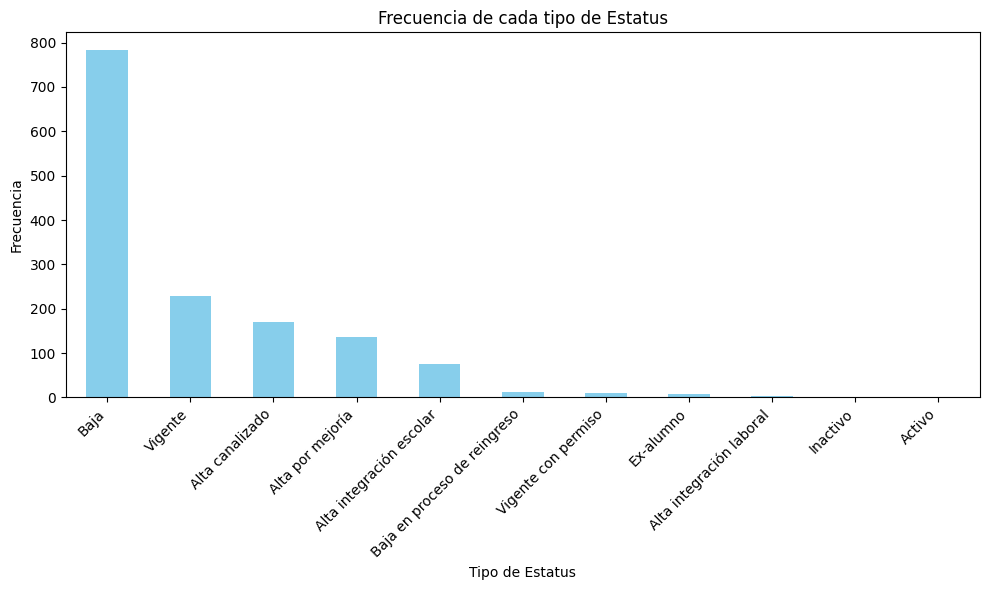

In [219]:
#ver cuanta variedad de datos en ESTATUS hay
estancias_unicas = df_imputed['Estatus'].unique()
numero_estancias_unicas = len(estancias_unicas)

print(f"Hay {numero_estancias_unicas} estancias únicas en la columna 'Estatus'.")
print("=======================================================================")
# verificar cuales son los tipos de Estatus que hay
tipos_estancias = df_imputed['Estatus'].unique()
conteo_estancias = df_imputed['Estatus'].value_counts()

print("Tipos de ESTATUS y sus frecuencias:")
for tipo in tipos_estancias:
    frecuencia = conteo_estancias[tipo]
    print(f"{tipo}: {frecuencia}")
# graficar los tipos de estatus

status_counts = df_imputed['Estatus'].value_counts()
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
status_counts.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de cada tipo de Estatus')
plt.xlabel('Tipo de Estatus')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar que las etiquetas se superpongan
plt.show()

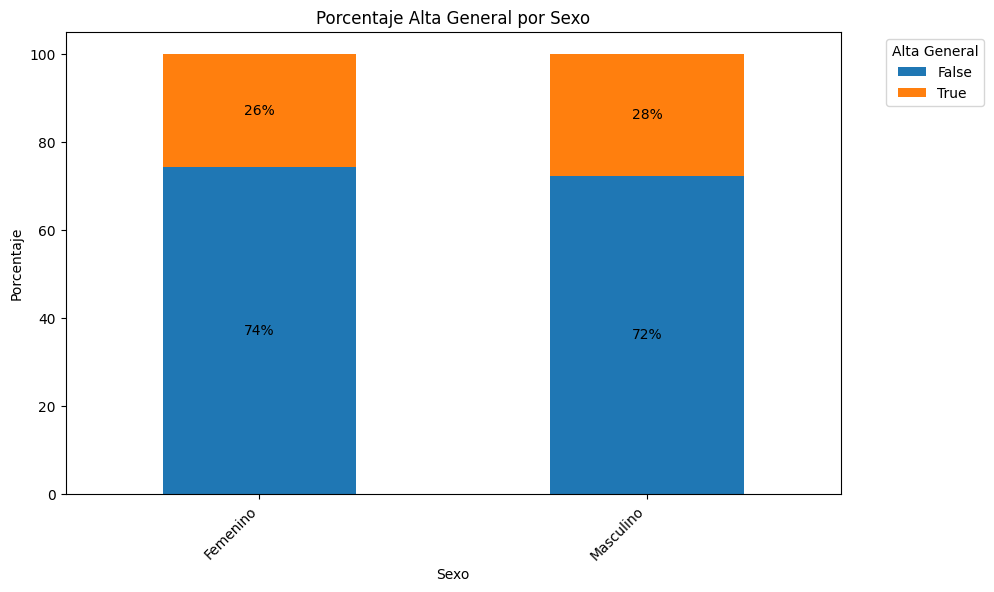

In [220]:
import seaborn as sns
import altair as alt

#Función para todas
def graficar_barras_apiladas_porcentaje(df, columna_x, columna_hue):

    # Tabulación cruzada
    tabla_cruzada = pd.crosstab(df[columna_x], df[columna_hue])

    # Calcula los porcentajes
    total = tabla_cruzada.sum(axis=1)
    porcentajes = tabla_cruzada.div(total, axis=0) * 100

    #Clases
    ax = porcentajes.plot(kind='bar', stacked=True, figsize=(10, 6))

    #Gráfico
    plt.title(f'Porcentaje {columna_hue} por {columna_x}')
    plt.xlabel(columna_x)
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=columna_hue, bbox_to_anchor=(1.05, 1), loc='upper left')

    #Porcentajes
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x + width/2,
                y + height/2,
                '{:.0f}%'.format(height),
                horizontalalignment='center',
                verticalalignment='center')


    #Gráfica
    plt.show()

graficar_barras_apiladas_porcentaje(df_imputed, 'Sexo', 'Alta General')

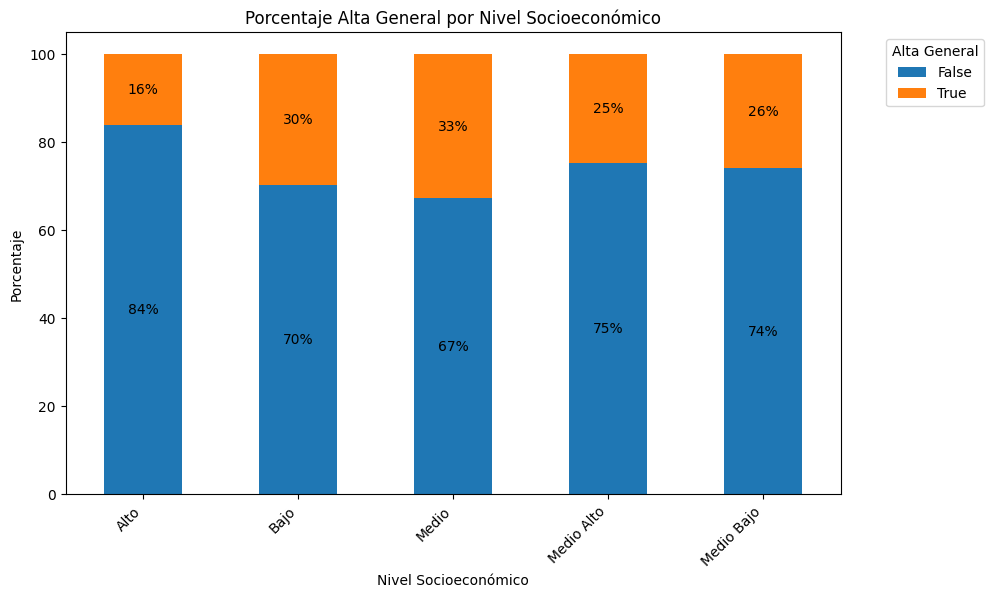

In [221]:
graficar_barras_apiladas_porcentaje(df_imputed, 'Nivel Socioeconómico', 'Alta General')

In [222]:
# Specify the path and filename for the CSV file
csv_file_path = '/content/drive/MyDrive/Base_NA_Final.csv' # Example: save to Google Drive

# Save the DataFrame to a CSV file
df_imputed.to_csv(csv_file_path, index=False) # Set index=False to avoid writing the DataFrame index as a column

print(f"DataFrame saved to {csv_file_path}")

DataFrame saved to /content/drive/MyDrive/Base_NA_Final.csv
